In [1]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import statsmodels.api as sm 

# Import the data

In [34]:
### Import the data

data = pd.read_csv('data/02_datawrangling_byzcta_out.csv', index_col=0)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
houseinc_1,16832.0,18649.956749,8998.317360,0.0,12599.000000,16942.500000,22910.000000,1.158070e+05
houseinc_2,16832.0,45757.347196,19993.049201,4280.0,32561.000000,41596.000000,53922.250000,2.377980e+05
houseinc_3,16832.0,73544.464116,30521.948580,13345.0,54332.250000,66688.500000,84444.000000,3.969010e+05
houseinc_4,16832.0,110695.061252,45551.785911,20331.0,83617.500000,99863.500000,123924.750000,8.579790e+05
houseinc_5,16832.0,222253.954907,106700.215022,54092.0,160721.500000,193372.000000,248643.500000,1.378088e+06
houseinc_top5,16832.0,368325.242990,201389.937722,76388.0,241551.500000,312925.500000,426926.500000,2.088063e+06
med_houseinc_12mon,16832.0,73141.710789,30072.669973,13137.0,54006.000000,66529.500000,84231.000000,2.500010e+05
household_public_assistance1,16832.0,5368.304717,6051.598170,46.0,883.000000,2668.500000,8318.250000,4.165300e+04
state_fips,16832.0,29.844938,14.918572,1.0,18.000000,30.000000,42.000000,5.600000e+01
nflood_total,16832.0,5.333591,7.361547,1.0,1.000000,3.000000,6.000000,1.750000e+02


In [5]:
print(data.shape)
data.dtypes

(16832, 27)


houseinc_1                            int64
houseinc_2                            int64
houseinc_3                            int64
houseinc_4                            int64
houseinc_5                            int64
houseinc_top5                         int64
med_houseinc_12mon                    int64
household_public_assistance1          int64
state_fips                            int64
nflood_total                          int64
nflood_2000s                        float64
nflood_2010s                        float64
flood_dur_hours_median              float64
flood_dur_hours_min                 float64
flood_dur_hours_max                 float64
delta_floods                        float64
houseinc_1_var                      float64
houseinc_2_var                      float64
houseinc_3_var                      float64
houseinc_4_var                      float64
houseinc_5_var                      float64
houseinc_top5_var                   float64
med_houseinc_12mon_var          

# Calculate metrics to try
 1. calculate a change in flood occurence
 2. calculate variance from the state median (remove state median)

In [36]:
## calculate change in floods as ratio

data['delta_floods'] = (data['nflood_2010s'] - data['nflood_2000s']) / (data['nflood_2010s'] + data['nflood_2000s'])

In [37]:
### calculate variation metrics - how much is a zip code outside the state median? 
metrics_to_calc = ['houseinc_1', 'houseinc_2', 'houseinc_3', 'houseinc_4', 'houseinc_5', 'houseinc_top5', 'med_houseinc_12mon', 
                   'household_public_assistance1', 'nflood_total', 'nflood_2000s', 'nflood_2010s']

for n in metrics_to_calc:
    data[n + '_var'] = data[n] / data[n + '_state_med']

##drop state median metrics for further analysis
drop_state_med = [x for x in data.columns if '_state_med' in x]
data.drop(drop_state_med, axis=1, inplace=True)


KeyError: 'houseinc_1_state_med'

# Check correlations of new variance metrics

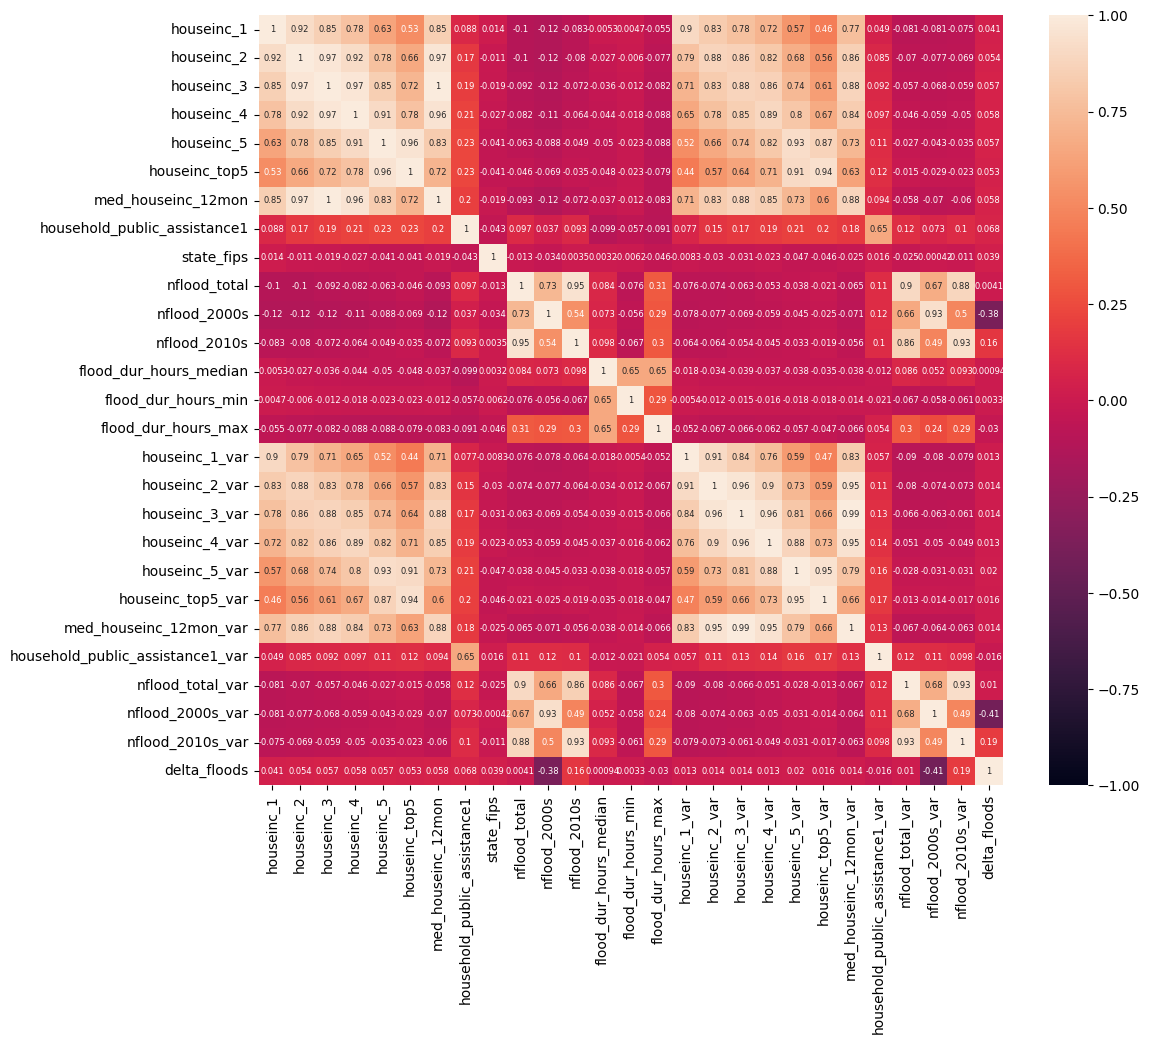

In [41]:
### show heatmap
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(data.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":6})
plt.show()


Pretty weak correlations... not sure if this will yield good results. 
Generally, variance metrics by state not as good correlation - remove for now


In [43]:
## drop variance columns
var_column_names = [x for x in data.columns if '_var' in x]
print(var_column_names)
data = data.drop(var_column_names, axis=1)


['houseinc_1_var', 'houseinc_2_var', 'houseinc_3_var', 'houseinc_4_var', 'houseinc_5_var', 'houseinc_top5_var', 'med_houseinc_12mon_var', 'household_public_assistance1_var', 'nflood_total_var', 'nflood_2000s_var', 'nflood_2010s_var']


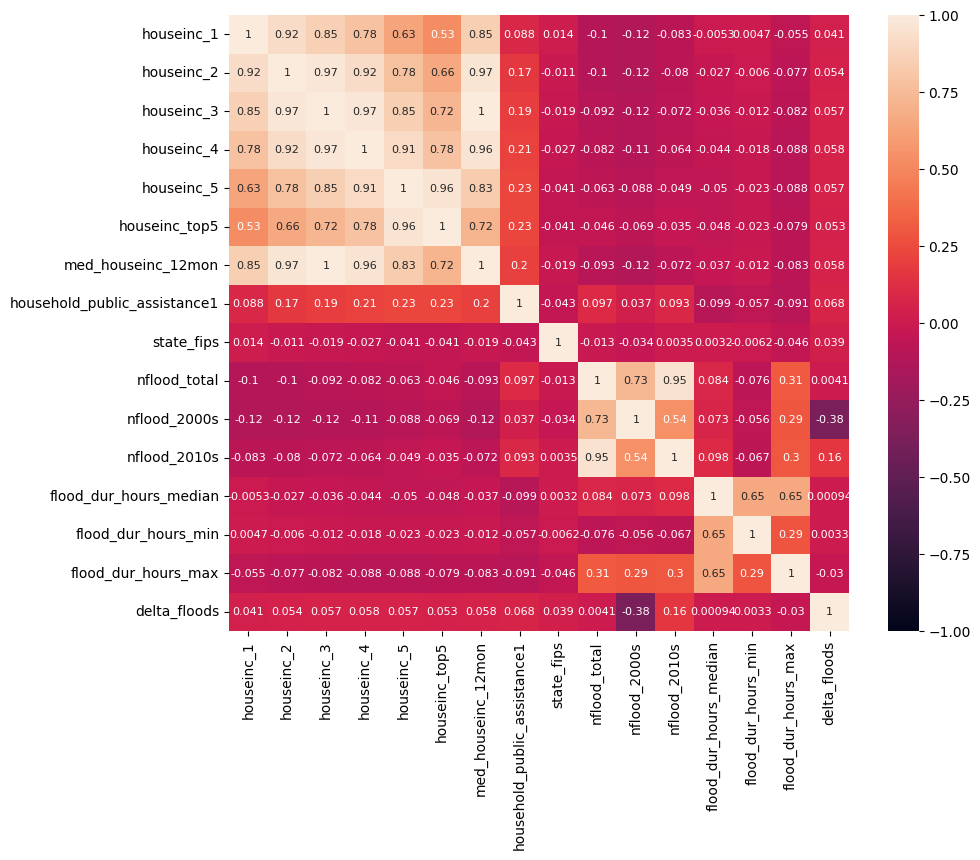

In [44]:
### show heatmap
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":8})
plt.show()


# Plot all the data

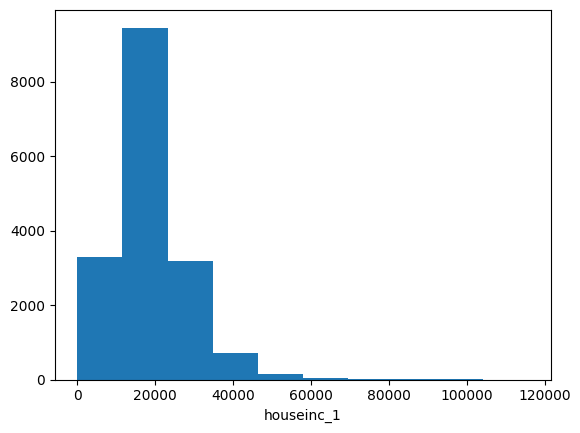

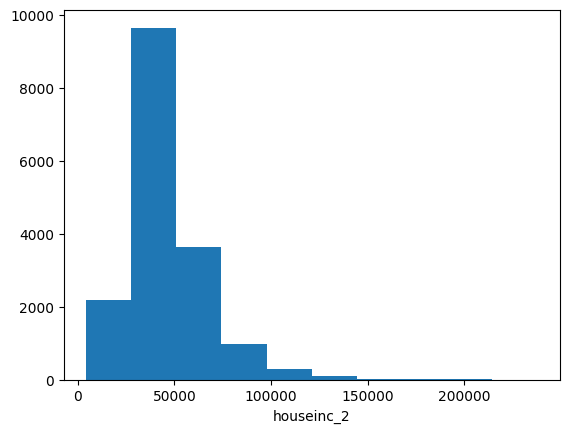

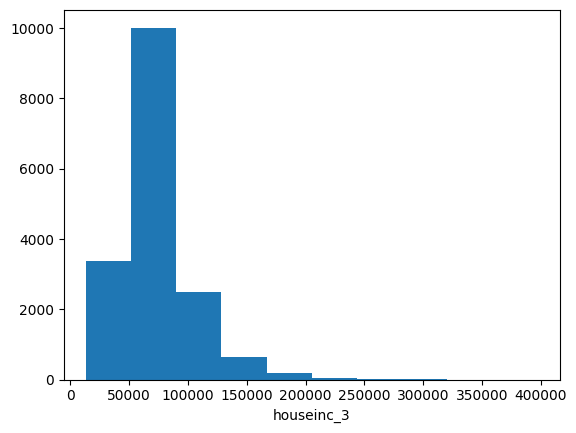

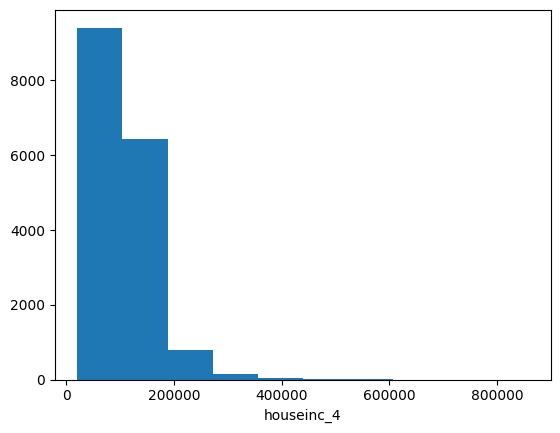

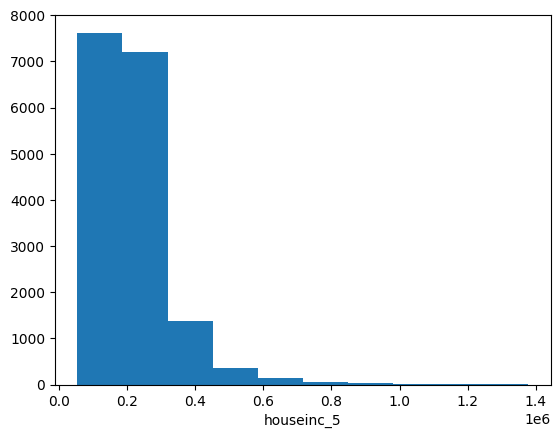

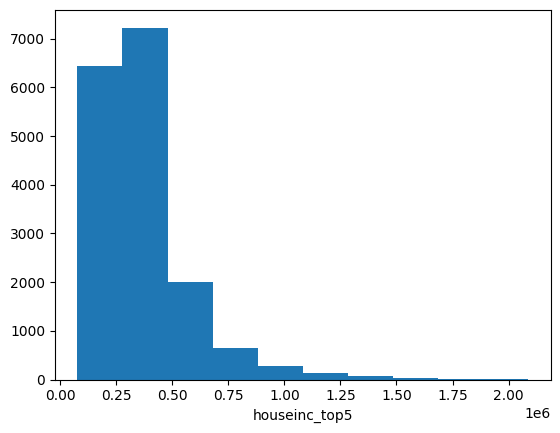

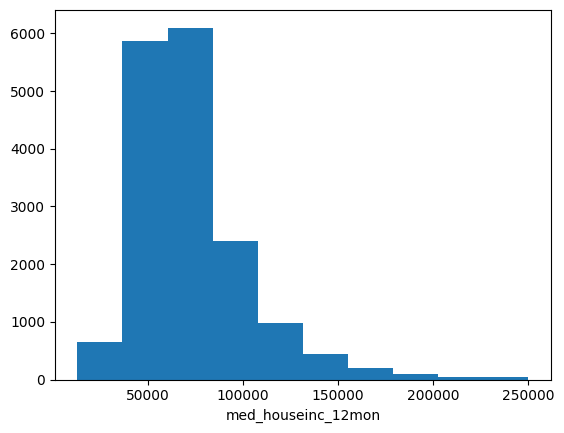

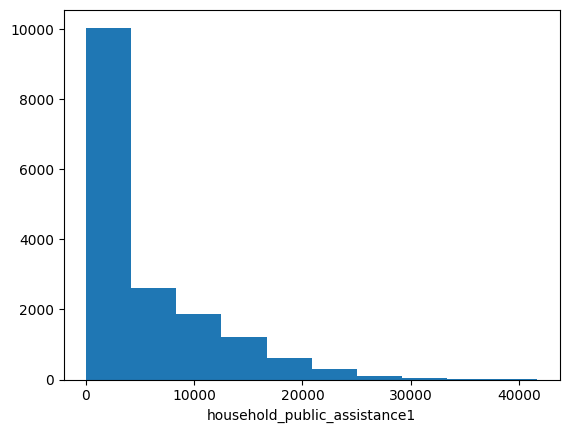

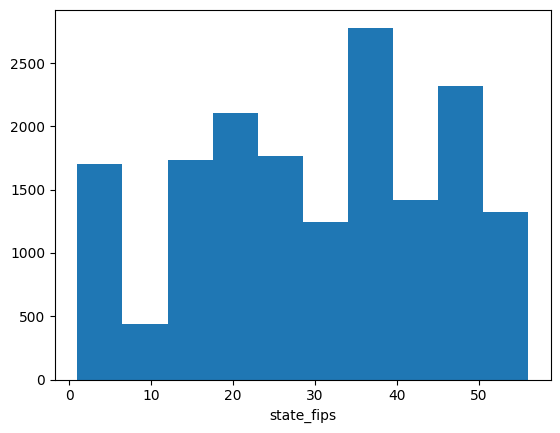

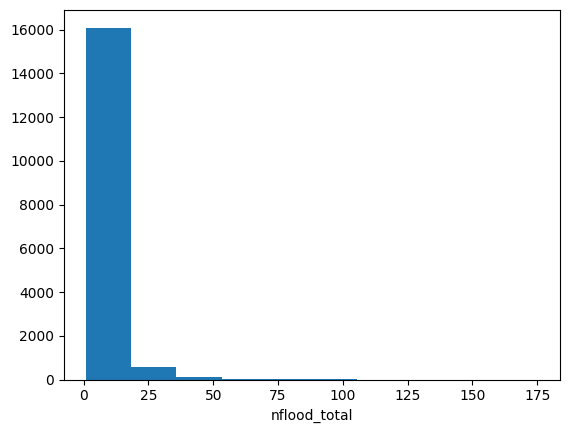

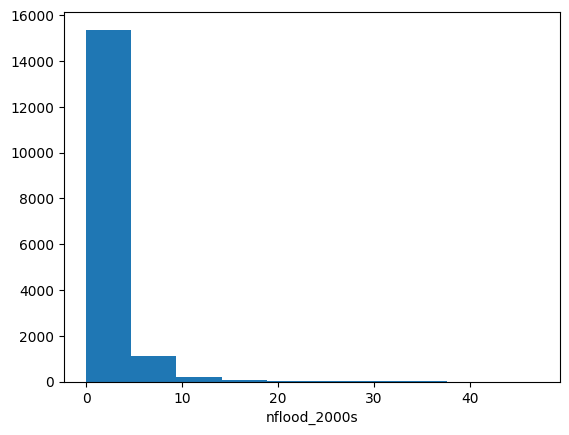

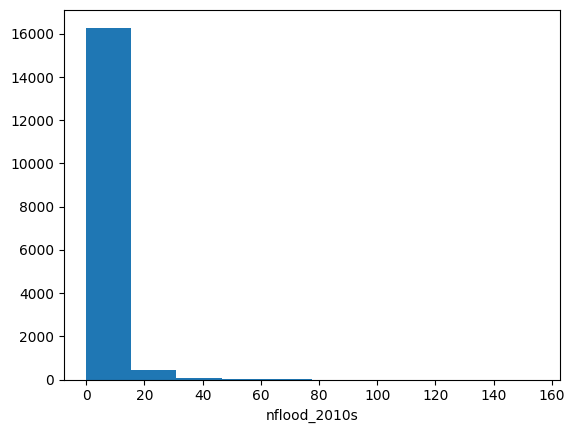

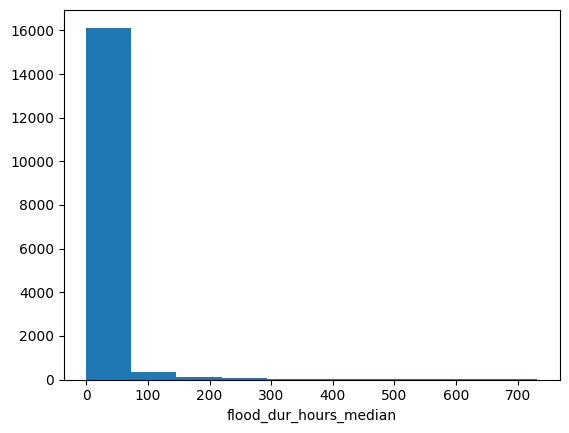

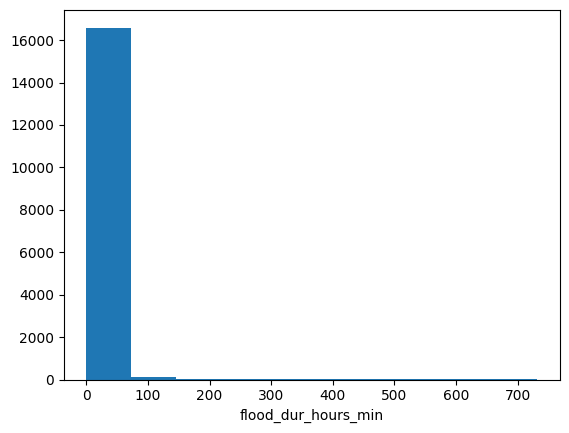

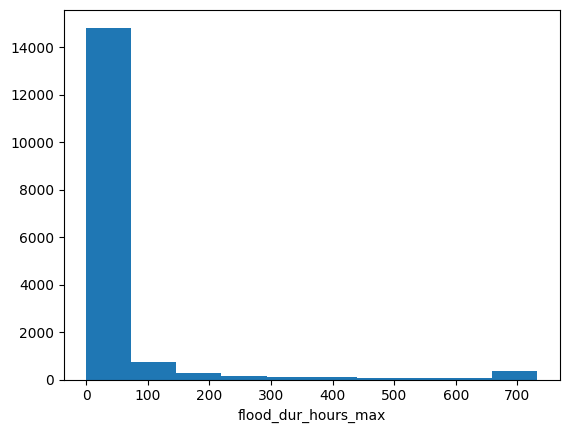

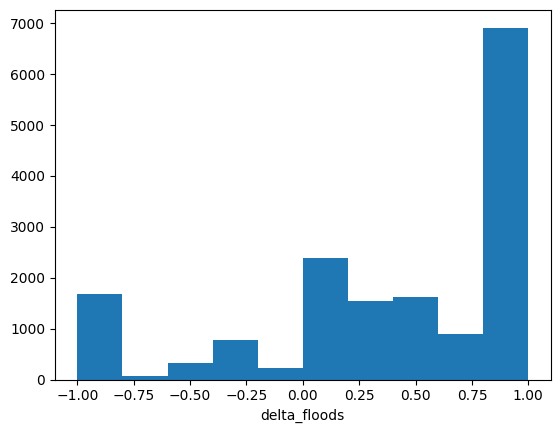

In [45]:
## plot each dataset

for n in data.columns:
    plt.hist(data[n])
    plt.xlabel(n)
    plt.show()


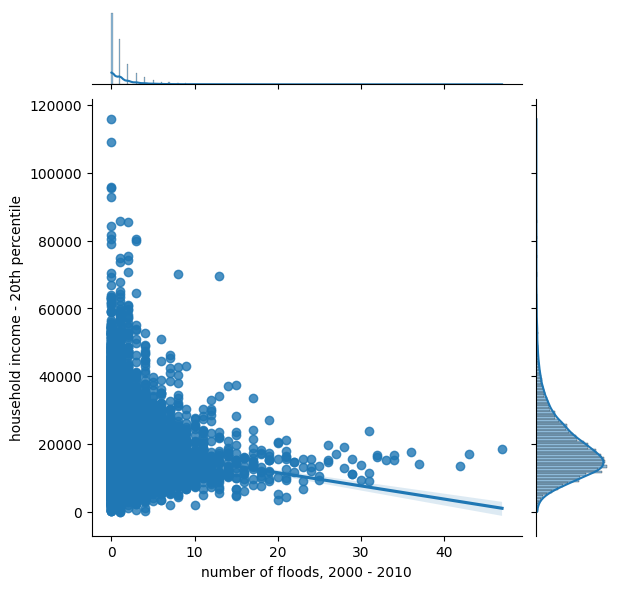

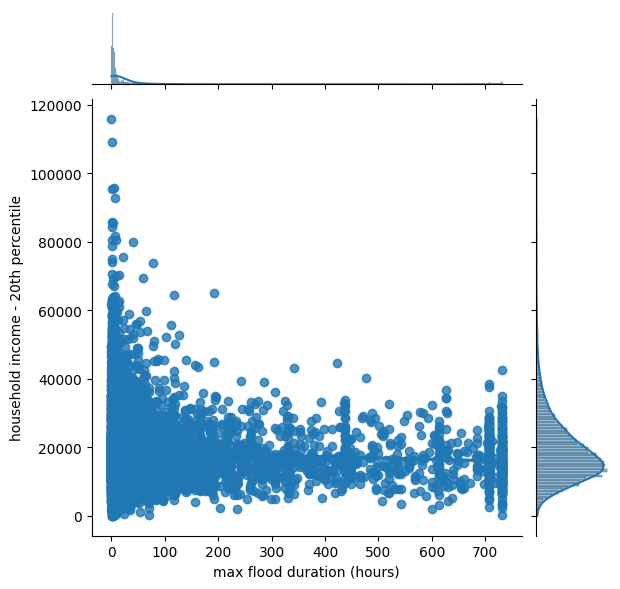

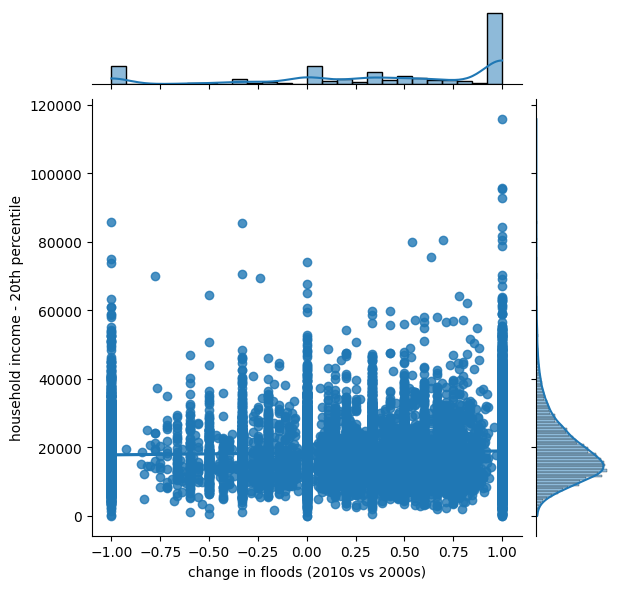

In [54]:
###plot 20th percentile income vs number of floods

sns.jointplot(data=data, x='nflood_2000s', y='houseinc_1', kind='reg')
plt.ylabel('household income - 20th percentile')
plt.xlabel('number of floods, 2000 - 2010')
plt.show()

sns.jointplot(data=data, x='flood_dur_hours_max', y='houseinc_1', kind='reg')
plt.ylabel('household income - 20th percentile')
plt.xlabel('max flood duration (hours)')
plt.show()

sns.jointplot(data=data, x='delta_floods', y='houseinc_1', kind='reg')
plt.ylabel('household income - 20th percentile')
plt.xlabel('change in floods (2010s vs 2000s)')
plt.show()


## Number of floods typically very small for most zip codes
Likley because of geography and not necessarily related to income at all... Perhaps think about finding a way to quantify distance from flooding source? 

some of the lowest-income zip codes have very few floods. How many have no floods at all? 


In [47]:
print(data.loc[data['nflood_total']==0, :].shape) ##no zips with no floods
data_morethan10 = data.loc[data['nflood_total']>10, :] ### zero floods with no zip codes
print(data_morethan10.shape) ## 2066 zips with more than 10 floods

(0, 16)
(2066, 16)


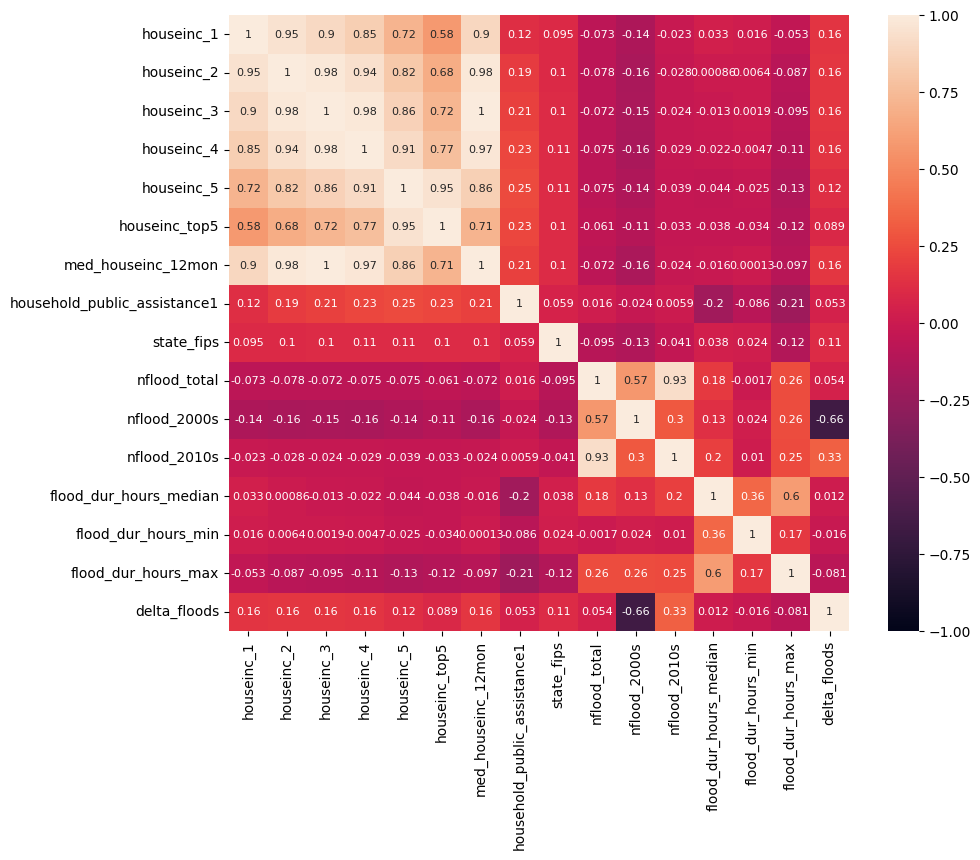

In [48]:
###repeat corr with this data
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data_morethan10.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":8})
plt.show()

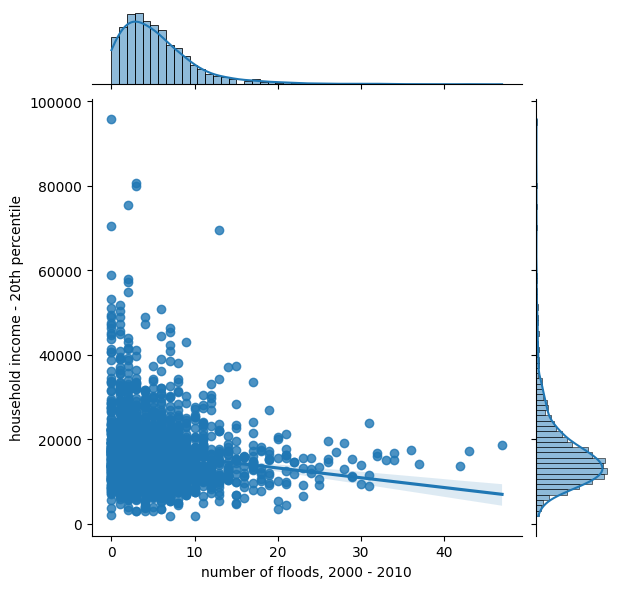

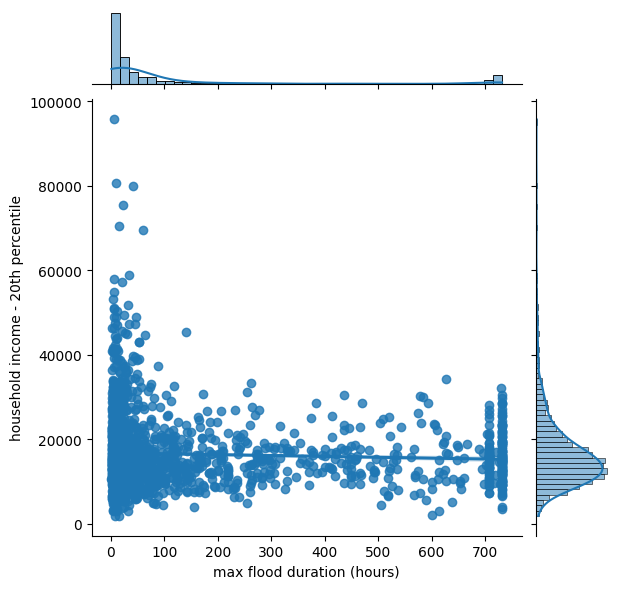

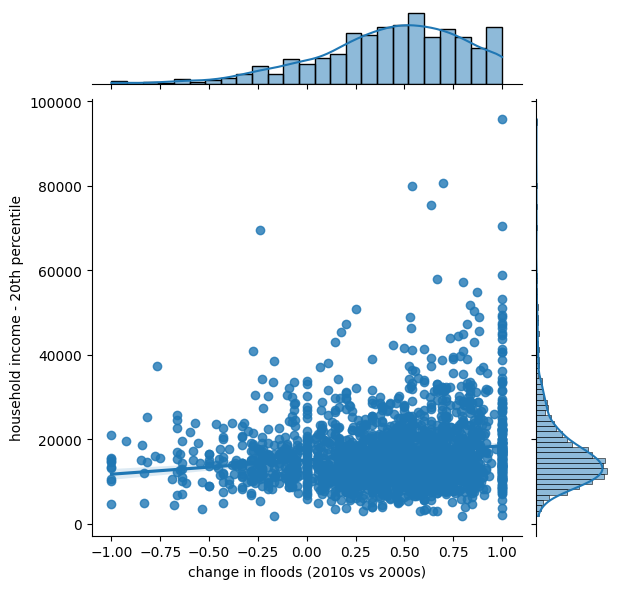

In [53]:
sns.jointplot(data=data_morethan10, x='nflood_2000s', y='houseinc_1', kind='reg')
plt.ylabel('household income - 20th percentile')
plt.xlabel('number of floods, 2000 - 2010')
plt.show()

sns.jointplot(data=data_morethan10, x='flood_dur_hours_max', y='houseinc_1', kind='reg')
plt.ylabel('household income - 20th percentile')
plt.xlabel('max flood duration (hours)')
plt.show()

sns.jointplot(data=data_morethan10, x='delta_floods', y='houseinc_1', kind='reg')
plt.ylabel('household income - 20th percentile')
plt.xlabel('change in floods (2010s vs 2000s)')
plt.show()

## remove floods less than 10
probably not helpful to remove floods less than 10. Data still not linear, and removes zips where num floods is low and income is high. 

## State visualization

# Conclusions

1. No missing values, no outliers suggesting a data error
2. Data is not linear and so linear correlation is very low. Flood occurence possibly a Poisson distribution.
3. Best choice of target variable seems to be 20th percentile income for each zip code.
4. A good starting place for explanatory variables seem to be number of floods between 2000 and 2010, change in floods, and max flood duration. 
5. Because data is not linear, modeling will likely begin with ML algorithms. However, a lot of the zip codes have very few floods - possibly because of proximity to flooding source. Look into calculating a flood source proximity metric. Possibly using NHD lines or similar (perhaps use max stream order within ZCTA?)
6. Also, investigate why every zcta has a flood. Seems surprising to me...)

